In [2]:
from code.ca_model import *
from code.read_data import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
from code.analyze import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import random

In [2]:
ROWS = COLS = 101
GENERATIONS = 500

In [9]:
history_csv_file = 'data/history_data.csv'
history_array = []
history_array = read_history(history_array, history_csv_file)

matrices_csv_file = 'data/matrices_data.csv'
all_M = read_matrix(ROWS, COLS, GENERATIONS, matrices_csv_file)

Importing completed, there are 100 history entries in total
Total tau reconstructed: 100


## 1. Time to Metastasis vs K1 and K2

In [23]:
# K1_values = [0.2, 0.25, 0.35, 0.45, 0.55, 0.65, 0.85, 0.9]
# K2_values = [0.2, 0.225, 0.25, 0.275, 0.3, 0.35, 0.375, 0.4]

K1_values = np.arange(0.2, 0.9, (0.9-0.2)/50)
K2_values = np.arange(0.2, 0.4, (0.4-0.2)/50)

In [ ]:
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

pickle_file_path = 'data/generation_above_50cluster_k2s.pkl'

with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

time_array = np.array(data)
time_array = np.array([[float(entry) if entry is not None else np.nan for entry in row] for row in time_array])

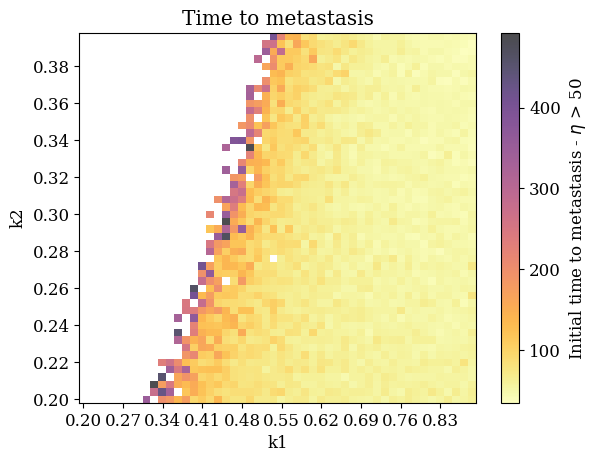

In [24]:
fig, ax = plt.subplots()
im = ax.imshow(time_array, cmap='inferno_r', interpolation='none', aspect='auto', origin='lower', alpha=0.7)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'Initial time to metastasis - $\eta$ > 50')

ax.set_xlabel('k1')
ax.set_ylabel('k2')
ax.set_xticks(np.arange(len(K1_values)))
ax.set_yticks(np.arange(len(K2_values)))
ax.set_xticklabels([f'{k:.2f}' for k in K1_values])
ax.set_yticklabels([f'{k:.2f}' for k in K2_values])

# Ensure that every tick label is displayed
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax.set_title('Time to metastasis')

plt.show()


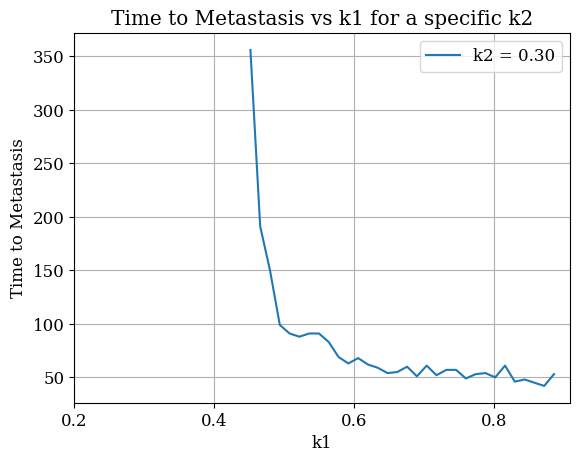

In [33]:
# Select the row for a specific k2 value
# Let's say we want to plot the line for k2 = 0.3
# Find the index in K2_values that is closest to 0.3
k2_index = (np.abs(K2_values - 0.3)).argmin()
selected_time_values = time_array[k2_index]

fig, ax = plt.subplots()
ax.plot(K1_values, selected_time_values, label=f'k2 = {K2_values[k2_index]:.2f}')
ax.set_xlabel('k1')
ax.set_ylabel('Time to Metastasis')
ax.grid(True)
ax.legend()
ax.set_xticks(np.arange(0.2, 0.9, 0.05))

# Ensure that every tick label is displayed and avoid overlap
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=6, steps=[1, 2, 5, 10]))
ax.set_title('Time to Metastasis vs k1 for a specific k2')

plt.show()


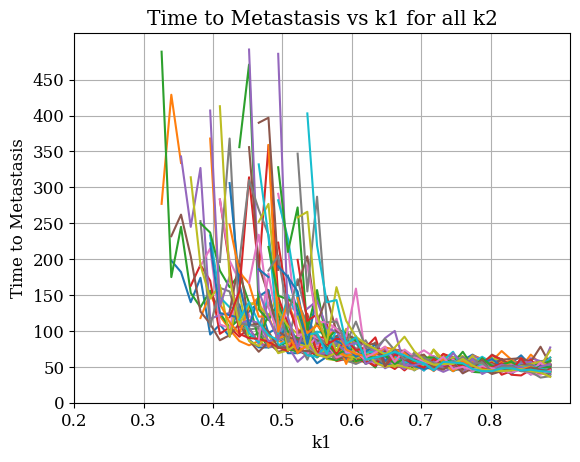

In [28]:
fig, ax = plt.subplots()

# Plot lines for each k2 value
for k2_index, k2_value in enumerate(K2_values):
    selected_time_values = time_array[k2_index]
    ax.plot(K1_values, selected_time_values, label=f'k2 = {k2_value:.2f}')

ax.set_xlabel('k1')
ax.set_ylabel('Time to Metastasis')
ax.set_xticks(np.arange(0.2, 0.9, 0.1))
ax.set_yticks(np.arange(0,500,50))
ax.set_title('Time to Metastasis vs k1 for all k2')
ax.grid(True) # grid for better readability

plt.show()


## 2. Finite Size Scaling

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

PHI = 1000
K3, K4 = 0.4, 0.4  # Define mitosis and apoptosis probabilities
RHO = 3.85


def initialize_grid(ROWS, COLS, CANCER_INIT_POSITIONS):
    """Initialize the grid with normal cells and initial cancer cells."""
    M = np.full((ROWS, COLS), 'N')
    for pos in CANCER_INIT_POSITIONS:
        M[pos] = 'C'
    return M

def sum_cell_type(M, cell_type):
    """Count the number of a specific cell type in the grid."""
    return np.sum(M == cell_type)

def calculate_n_prime(M):
    """Calculate the total number of cancerous, edge, and dead cells."""
    c = sum_cell_type(M, 'C')
    e = sum_cell_type(M, 'E')
    d = sum_cell_type(M, 'D')
    n_prime = c + e + d
    return n_prime

def origin_distance(M, ORIGIN):
    """Calculate the average distance of cancer cells from the origin."""
    n_prime = calculate_n_prime(M)
    R = 0
    for i in range(len(M)):
        for j in range(len(M[0])):
            if M[i, j] == 'C':
                R += math.sqrt((i - ORIGIN[0]) ** 2 + (j - ORIGIN[1]) ** 2)
    R = R / n_prime if n_prime else 0
    return R

def density_development(M, ORIGIN):
    """Calculate the density development of the tumor."""
    n_prime = calculate_n_prime(M)
    R = origin_distance(M, ORIGIN)
    return n_prime / R ** 2 if R else 0

def mitosis_probability(k, n):
    """Calculate the probability of a cell undergoing mitosis."""
    return k * (1 - n / PHI)

def get_quadrant(r, c):
    """ Get quadrant of coordinates relative to ORIGIN. """
    if r <= ORIGIN[0] and c > ORIGIN[1]:
        return 'I'
    elif r <= ORIGIN[0] and c <= ORIGIN[1]:
        return 'II'
    elif r > ORIGIN[0] and c <= ORIGIN[1]:
        return 'III'
    else:
        return 'IV'


def mitosis(M, newM, r, c, dense):

    # Define directions relative to the cell position
    up, rt, dn, lt = (r - 1, c), (r, c + 1), (r + 1, c), (r, c - 1)
    # Get the quadrant to determine division direction
    quadrant = get_quadrant(r, c)
    # Maps for cell division based on tumor density
    dense_map = {'I': [up, rt], 'II': [lt, up], 'III': [dn, lt], 'IV': [rt, dn]}
    not_dense_map = {'I': [dn, lt], 'II': [rt, dn], 'III': [up, rt], 'IV': [lt, up]}
    # Exclude cells that are not normal for division
    not_normal = ('E', 'D')
    # Choose the appropriate map based on density
    map_choice = dense_map if dense else not_dense_map
    choices = map_choice[quadrant]

    # Attempt to divide the cell in the chosen directions
    for choice in choices:
        if newM[choice] not in not_normal:
            newM[choice] = 'C'
            break
    return newM

def simulate_tumor_growth_one_step(M, k1, k2, ROWS, COLS, ORIGIN):
  
    newM = np.copy(M)
    dense = (density_development(M,ORIGIN) > RHO)

    for r in range(1, ROWS - 1):
        for c in range(1, COLS - 1):
            if M[r, c] == 'C':
                mitosis_prob = mitosis_probability(k1, sum_cell_type(M, 'C'))
                if random.random() < mitosis_prob:
                    newM = mitosis(M, newM, r, c, dense)
                elif random.random() < k2:
                    newM[r, c] = 'E'
            elif M[r, c] == 'E' and random.random() < K3:
                newM[r, c] = 'D'
            elif M[r, c] == 'D' and random.random() < K4:
                newM[r, c] = 'N'
    return newM

In [4]:
def simulate_and_find_metastasis(generations, rows, cols, k1, k2):

    ORIGIN = (cols // 2, rows // 2)
    CANCER_INIT_POSITIONS = [(ORIGIN[0], ORIGIN[1]), (ORIGIN[0] + 1, ORIGIN[1]),
                            (ORIGIN[0] - 1, ORIGIN[1]), (ORIGIN[0], ORIGIN[1] - 1),
                            (ORIGIN[0], ORIGIN[1] + 1)]

    M = initialize_grid(rows, cols, CANCER_INIT_POSITIONS)
    num_clusters_list = []
    Tm = None

    for g in range(generations):
        M = simulate_tumor_growth_one_step(M, k1, k2, rows, cols, ORIGIN)
        clusters = find_clusters(M, rows, cols)
        num_clusters = len(clusters)
        num_clusters_list.append(len(clusters))
        
        if num_clusters > 50 and Tm is None:
            Tm = g

    return num_clusters_list, Tm

# Now call this function inside your loop
clusters = {}
time_to_metastasis = {}

# Loop over each system size and K1
for system_size in range(100, 501, 100):
    rows = cols = system_size  # Assuming a square grid
    clusters[system_size] = {}
    time_to_metastasis[system_size] = {}
    
    for K1 in np.arange(0, 1, 0.1):
        cluster_at_each_gen, Tm = simulate_and_find_metastasis(400, system_size, system_size, K1, 0.3)
        clusters[system_size][K1] = cluster_at_each_gen
        time_to_metastasis[system_size][K1] = Tm
            
        print ("Size:", system_size, "k1 :", K1, "done")
        

Size: 100 k1 : 0.0 done
Size: 100 k1 : 0.1 done
Size: 100 k1 : 0.2 done
Size: 100 k1 : 0.30000000000000004 done
Size: 100 k1 : 0.4 done
Size: 100 k1 : 0.5 done
Size: 100 k1 : 0.6000000000000001 done
Size: 100 k1 : 0.7000000000000001 done
Size: 100 k1 : 0.8 done
Size: 100 k1 : 0.9 done
Size: 200 k1 : 0.0 done
Size: 200 k1 : 0.1 done
Size: 200 k1 : 0.2 done
Size: 200 k1 : 0.30000000000000004 done
Size: 200 k1 : 0.4 done
Size: 200 k1 : 0.5 done
Size: 200 k1 : 0.6000000000000001 done
Size: 200 k1 : 0.7000000000000001 done
Size: 200 k1 : 0.8 done
Size: 200 k1 : 0.9 done
Size: 300 k1 : 0.0 done
Size: 300 k1 : 0.1 done
Size: 300 k1 : 0.2 done
Size: 300 k1 : 0.30000000000000004 done
Size: 300 k1 : 0.4 done
Size: 300 k1 : 0.5 done
Size: 300 k1 : 0.6000000000000001 done
Size: 300 k1 : 0.7000000000000001 done
Size: 300 k1 : 0.8 done
Size: 300 k1 : 0.9 done
Size: 400 k1 : 0.0 done
Size: 400 k1 : 0.1 done
Size: 400 k1 : 0.2 done
Size: 400 k1 : 0.30000000000000004 done
Size: 400 k1 : 0.4 done
Size: 

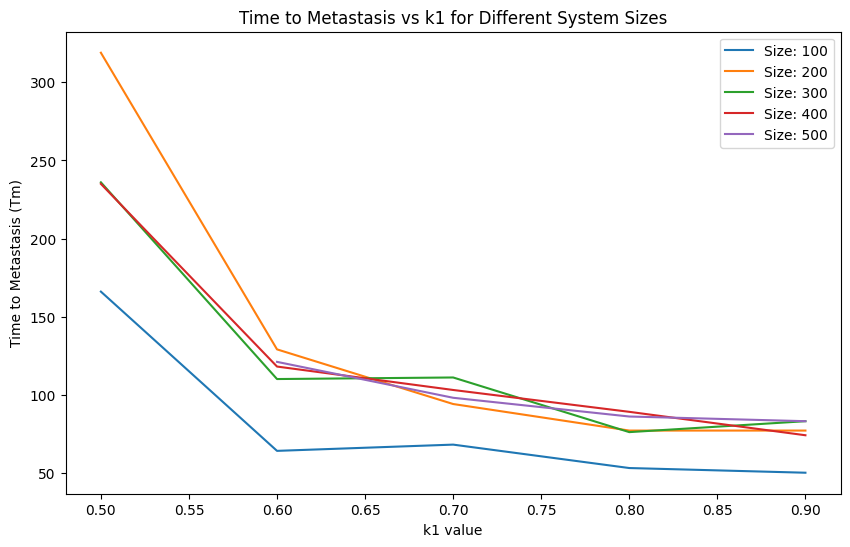

In [9]:
plt.figure(figsize=(10, 6))

# Plotting each system size
for system_size in time_to_metastasis:
    # Extracting k1 values and corresponding Tm for this system size
    k1_values = list(time_to_metastasis[system_size].keys())
    Tm_values = list(time_to_metastasis[system_size].values())

    # Plotting the line for this system size
    plt.plot(k1_values, Tm_values, label=f'Size: {system_size}')

plt.xlabel('k1 value')
plt.ylabel('Time to Metastasis (Tm)')
plt.title('Time to Metastasis vs k1 for Different System Sizes')
plt.legend()
plt.show()

In [11]:
Tm_values

[None, None, None, None, None, None, 121, 98, 86, 83]

In [10]:
k1_values

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

In [5]:
import json

# Saving a dictionary as JSON
with open('data/time_to_metastasis.json', 'w') as f:
    json.dump(time_to_metastasis, f)

with open('data/clusters.json', 'w') as f:
    json.dump(clusters, f)

# # Loading a dictionary from JSON
# with open('data.json', 'r') as f:
#     your_dictionary = json.load(f)


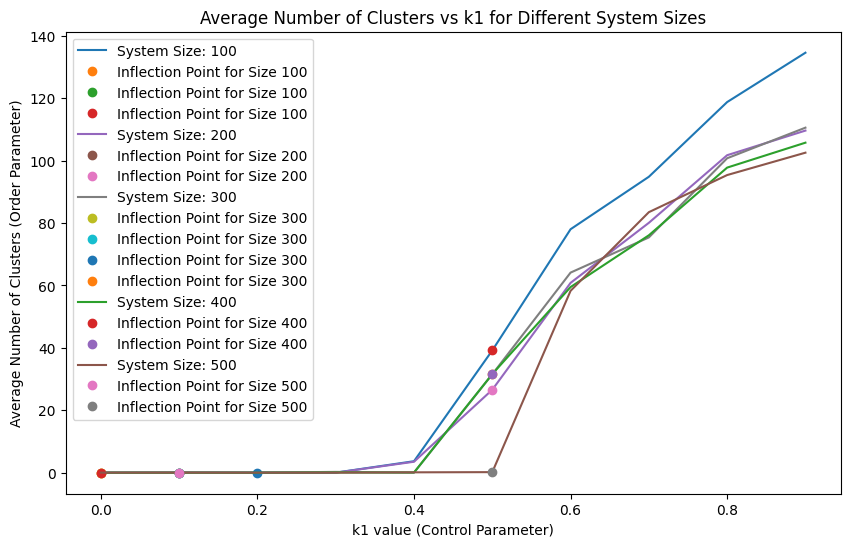

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to compute the second derivative using a central finite difference method
def second_derivative(y, x):
    dy = np.gradient(y, x)
    d2y = np.gradient(dy, x)
    return d2y

# Prepare the plot
plt.figure(figsize=(10, 6))

# Loop through each system size
for system_size, k1_dict in clusters.items():
    k1_values = np.array(sorted(k1_dict.keys()))
    mean_cluster_counts = np.array([np.mean(k1_dict[k1]) for k1 in k1_values])

    # Calculate second derivative of cluster counts
    sec_deriv_cluster_counts = second_derivative(mean_cluster_counts, k1_values)

    # Plot the mean cluster count for each k1 value
    plt.plot(k1_values, mean_cluster_counts, label=f'System Size: {system_size}')

    # Find indices where the second derivative changes sign (zero-crossings)
    zero_crossings = np.where(np.diff(np.sign(sec_deriv_cluster_counts)))[0]
    
    # Plot the zero-crossing points
    for zc in zero_crossings:
        # Ensure we don't go out of index bounds due to differentiation
        if zc < len(k1_values) - 1:
            plt.plot(k1_values[zc], mean_cluster_counts[zc], 'o', label=f'Inflection Point for Size {system_size}')

# Add axis labels and a title
plt.xlabel('k1 value (Control Parameter)')
plt.ylabel('Average Number of Clusters (Order Parameter)')
plt.title('Average Number of Clusters vs k1 for Different System Sizes')
plt.legend()

# Show the plot
plt.show()


AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

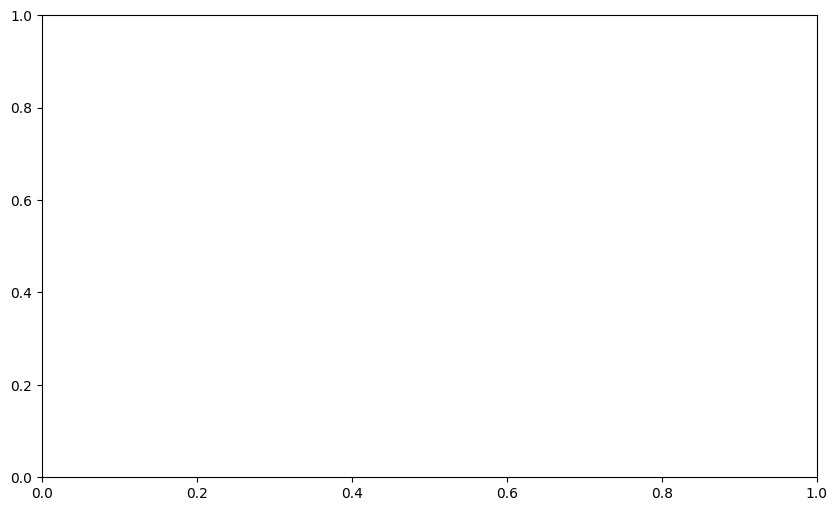

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

# Define a color cycler, for example using the default Matplotlib color cycle
color_cycler = plt.rcParams['axes.prop_cycle']

# Helper function to compute the second derivative using a central finite difference method
def second_derivative(y, x):
    dy = np.gradient(y, x)
    d2y = np.gradient(dy, x)
    return d2y

# Prepare the plot
plt.figure(figsize=(10, 6))

# Use the color cycler to assign colors
plt.gca().set_prop_cycle(color_cycler)

# Loop through each system size
for system_size, k1_dict in clusters.items():
    k1_values = np.array(sorted(k1_dict.keys()))
    mean_cluster_counts = np.array([np.mean(k1_dict[k1]) for k1 in k1_values])

    # Calculate second derivative of cluster counts
    sec_deriv_cluster_counts = second_derivative(mean_cluster_counts, k1_values)
    
    # Get the current color from the cycle
    current_color = next(plt.gca()._get_lines.prop_cycler)['color']

    # Plot the mean cluster count for each k1 value
    plt.plot(k1_values, mean_cluster_counts, label=f'System Size: {system_size}', color=current_color)

    # Find indices where the second derivative changes sign (zero-crossings)
    zero_crossings = np.where(np.diff(np.sign(sec_deriv_cluster_counts)))[0]
    
    # Plot the zero-crossing points using the same color
    for zc in zero_crossings:
        # Ensure we don't go out of index bounds due to differentiation
        if zc < len(k1_values) - 1:
            plt.plot(k1_values[zc], mean_cluster_counts[zc], 'o', color=current_color)  # Use the same color

# Add axis labels and a title
plt.xlabel('k1 value (Control Parameter)')
plt.ylabel('Average Number of Clusters (Order Parameter)')
plt.title('Average Number of Clusters vs k1 for Different System Sizes')
plt.legend()

# Show the plot
plt.show()
